# Выполнил: Филоненко Никита Дмитриевич

-----

QR-код (ссылка на репозиторий с проектом)

[Решение на GitHub](https://github.com/nikfilonenko/video_gen_trends_analysis)

![](../../assets/qr-code.png)

# Оглавление

[Описание тестового задания](#0.1)
1. [Сбор данных через arXiv API](#01)
2. [EDA](#02)
    - [Получение общего представления о данных](#02.1)
    - [Предобработка текста для анализа](#02.2)
3.


## Описание тестового задания <a name="0.1"></a>

Задача - выделить основные тренды в видео генерации в 2024 году.

1. Получить метаданные статей с arXiv (любым способом) по теме “видео генерация”, выпущенных в 2024 году.
    
2. Написать код для выделения основных тем/трендов.
    
- Будет плюсом, если каждая тема будет представлена связным словосочетанием/предложением

3. Представить визуализацию результатов.
    


# Решение

### Импортируем необходимые модули 

In [1]:
import pandas as pd
import numpy as np
import arxiv
import matplotlib.pyplot as plt
import seaborn as sns

для получения метаданных статей из arXiv будем использовать его API, вместо написания парсера

поскольку:

- у arXiv нет жестких ограничений, платных тарифов

- API предоставляет доступ ко всему необходимому для выполнения данного задания

- лимит в 10 000 результатов на запрос – этого более чем достаточно

- соответственно нет жесткого rate limit, если не спамить слишком часто

- использование API избавит от лишней предобработки текста (например html теги)



## 1. Сбор данных через arXiv API <a name="01"></a>

будем использовать библиотеку arxiv, которая предоставляет удобный высокоуровневый интерфейс для работы с API arXiv

In [174]:
query = (
    'all:video generation OR all:video synthesis OR '
    'all:diffusion video OR all:GAN video OR '
    'all:text-to-video OR all:image-to-video OR '
    'all:scene generation '
    'AND submittedDate:[20240101 TO 20241231]'
)

search = arxiv.Search(
    query=query,
    max_results=150000,
    sort_by=arxiv.SortCriterion.Relevance,
    sort_order=arxiv.SortOrder.Ascending
)

выполним ленивую загрузку метаданных, создав генератор через `client.results(search)`, благодаря чему с экономим на оперативной памяти и времени начальной загрузки данных

также, учитывая тот факт, что arXiv API не позволяет фильтровать запросы по конкретному году (в нашем случае — 2024), при формировании набора данных дополнительно проверим соответствие года публикации, чтобы гарантировать включение только статей, опубликованных за 2024 год

In [175]:
client = arxiv.Client(
    page_size=500,
    delay_seconds=5,
    num_retries=5
)

papers = []

current_year = 2024

try:
    for result in client.results(search):
        if result.published.year == current_year:
            papers.append({
                "title": result.title,
                "abstract": result.summary,
                "published": result.published,
                "authors": [a.name for a in result.authors],
                "url": result.entry_id
            })
except arxiv.UnexpectedEmptyPageError:
    print("Достигнут предел доступных результатов")

df = pd.DataFrame(papers)

Достигнут предел доступных результатов


In [203]:
from colorama import Fore, Style

print(f"Сколько всего статей 2024 года получено: {Fore.GREEN}{len(df)}{Style.RESET_ALL}")

Сколько всего статей 2024 года получено: 2100


Итак, собранные имеют следующую структуру:

- `title` - заголовок статьи
- `abstract` - аннотация статьи
- `published` - полная дата и время публикации статьи
- `authors` - списки авторов статей
- `url` - ссылка на статью в arXiv 

In [137]:
df

,title,abstract,published,authors,url
0,Video to Video Generative Adversarial Network ...,The development of sophisticated models for vi...,2024-10-28 01:35:10+00:00,"[Yintai Ma, Diego Klabjan, Jean Utke]",http://arxiv.org/abs/2410.20657v1
1,Contrastive Sequential-Diffusion Learning: Non...,Generated video scenes for action-centric sequ...,2024-07-16 15:03:05+00:00,"[Vasco Ramos, Yonatan Bitton, Michal Yarom, Id...",http://arxiv.org/abs/2407.11814v3
2,ReCapture: Generative Video Camera Controls fo...,"Recently, breakthroughs in video modeling have...",2024-11-07 18:59:45+00:00,"[David Junhao Zhang, Roni Paiss, Shiran Zada, ...",http://arxiv.org/abs/2411.05003v1
3,"StreamingT2V: Consistent, Dynamic, and Extenda...",Text-to-video diffusion models enable the gene...,2024-03-21 18:27:29+00:00,"[Roberto Henschel, Levon Khachatryan, Daniil H...",http://arxiv.org/abs/2403.14773v1
4,FreeLong: Training-Free Long Video Generation ...,Video diffusion models have made substantial p...,2024-07-29 11:52:07+00:00,"[Yu Lu, Yuanzhi Liang, Linchao Zhu, Yi Yang]",http://arxiv.org/abs/2407.19918v1
...,...,...,...,...,...
2095,Recording dynamic facial micro-expressions wit...,We present an approach of utilizing a multi-ca...,2024-10-02 19:30:21+00:00,"[Lucas Kreiss, Weiheng Tang, Ramana Balla, Xi ...",http://arxiv.org/abs/2410.01973v1
2096,FLAASH: Flow-Attention Adaptive Semantic Hiera...,The proliferation of tobacco-related content o...,2024-10-25 17:20:22+00:00,"[Naga VS Raviteja Chappa, Page Daniel Dobbs, B...",http://arxiv.org/abs/2410.19896v2
2097,MSEG-VCUQ: Multimodal SEGmentation with Enhanc...,High-speed video (HSV) phase detection (PD) se...,2024-11-12 00:54:26+00:00,"[Chika Maduabuchi, Ericmoore Jossou, Matteo Bu...",http://arxiv.org/abs/2411.07463v4
2098,Principles of Visual Tokens for Efficient Vide...,Video understanding has made huge strides in r...,2024-11-20 14:09:47+00:00,"[Xinyue Hao, Gen Li, Shreyank N Gowda, Robert ...",http://arxiv.org/abs/2411.13626v2


In [148]:
df.to_csv("data/data_arxiv_video_generation_2024.csv", index=False)

## 2. EDA <a name="02"></a>

#### 2.1 Получение общего представления собранных данных

In [2]:
df = pd.read_csv(
    '../../data/data_arxiv_video_generation_2024.csv', 
    sep=',',
    engine='python',
    encoding='utf'
)

df.shape

(2100, 5)

In [3]:
df.head()

,title,abstract,published,authors,url
0,Video to Video Generative Adversarial Network ...,The development of sophisticated models for vi...,2024-10-28 01:35:10+00:00,"['Yintai Ma', 'Diego Klabjan', 'Jean Utke']",http://arxiv.org/abs/2410.20657v1
1,Contrastive Sequential-Diffusion Learning: Non...,Generated video scenes for action-centric sequ...,2024-07-16 15:03:05+00:00,"['Vasco Ramos', 'Yonatan Bitton', 'Michal Yaro...",http://arxiv.org/abs/2407.11814v3
2,ReCapture: Generative Video Camera Controls fo...,"Recently, breakthroughs in video modeling have...",2024-11-07 18:59:45+00:00,"['David Junhao Zhang', 'Roni Paiss', 'Shiran Z...",http://arxiv.org/abs/2411.05003v1
3,"StreamingT2V: Consistent, Dynamic, and Extenda...",Text-to-video diffusion models enable the gene...,2024-03-21 18:27:29+00:00,"['Roberto Henschel', 'Levon Khachatryan', 'Dan...",http://arxiv.org/abs/2403.14773v1
4,FreeLong: Training-Free Long Video Generation ...,Video diffusion models have made substantial p...,2024-07-29 11:52:07+00:00,"['Yu Lu', 'Yuanzhi Liang', 'Linchao Zhu', 'Yi ...",http://arxiv.org/abs/2407.19918v1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      2100 non-null   object
 1   abstract   2100 non-null   object
 2   published  2100 non-null   object
 3   authors    2100 non-null   object
 4   url        2100 non-null   object
dtypes: object(5)
memory usage: 82.2+ KB


размерность сформированного DataFrame`а: 2100 строк и 5 столбцов

- пропуски в данных отсутствуют
- тип данных у 5 столбцов - object (строка)

необходимо привести published к правильному data type, т.е. к datetime, а также извлечь из него несколько признаков: год и месяц

это позволит удобнее и детальнее проанализировать временные тенденции в полученных исследованиях 

In [5]:
df.dtypes

title        object
abstract     object
published    object
authors      object
url          object
dtype: object

In [6]:
df.duplicated(keep='first').sum()

0

дубликаты в данных также отсутствуют

- получим описательные статистики для текстовых данных

In [7]:
df.describe()

,title,abstract,published,authors,url
count,2100,2100,2100,2100,2100
unique,2100,2100,2098,2091,2100
top,Video to Video Generative Adversarial Network ...,The development of sophisticated models for vi...,2024-12-12 18:59:54+00:00,['Jinwei Lin'],http://arxiv.org/abs/2410.20657v1
freq,1,1,2,2,1


- `title, abstract, url` - столбцы с полностью уникальными значениями (2100 из 2100)

- `published` содержит 2098 уникальных значений (значит некоторые публикации были соверщены в одно время)

- `authors` содержит 2091 уникальных значений (небольшое кол-во авторских коллективов выпускало более одной статьи за год по теме, связанной с видео генерацией)


в целом информация ожидаемая и предсказуемая

In [8]:
df.isna().sum()

title        0
abstract     0
published    0
authors      0
url          0
dtype: int64

In [9]:
df['title'][0]

'Video to Video Generative Adversarial Network for Few-shot Learning Based on Policy Gradient'

In [10]:
df['abstract'][0]

'The development of sophisticated models for video-to-video synthesis has been\r\nfacilitated by recent advances in deep reinforcement learning and generative\r\nadversarial networks (GANs). In this paper, we propose RL-V2V-GAN, a new deep\r\nneural network approach based on reinforcement learning for unsupervised\r\nconditional video-to-video synthesis. While preserving the unique style of the\r\nsource video domain, our approach aims to learn a mapping from a source video\r\ndomain to a target video domain. We train the model using policy gradient and\r\nemploy ConvLSTM layers to capture the spatial and temporal information by\r\ndesigning a fine-grained GAN architecture and incorporating spatio-temporal\r\nadversarial goals. The adversarial losses aid in content translation while\r\npreserving style. Unlike traditional video-to-video synthesis methods requiring\r\npaired inputs, our proposed approach is more general because it does not\r\nrequire paired inputs. Thus, when dealing wi

как можно заметить данные требуют нормализации, стандартизации и очистки

особенно явно заметен символ новой строки `\n`

- приведем published к необходимому data type, а также создадим на его основе два новых столбца

In [11]:
df['published'] = pd.to_datetime(df['published'])

df['year_publisher'] = df['published'].dt.year
df['month_publisher'] = df['published'].dt.month

df.drop(columns=['published'], axis=1, inplace=True)

In [12]:
df[['year_publisher', 'month_publisher']]

,year_publisher,month_publisher
0,2024,10
1,2024,7
2,2024,11
3,2024,3
4,2024,7
...,...,...
2095,2024,10
2096,2024,10
2097,2024,11
2098,2024,11


все статьи пренадлежат к одному году

In [13]:
df['year_publisher'].unique()

array([2024])

In [14]:
df['month_publisher'].value_counts()

month_publisher
12    309
11    216
10    209
3     204
6     194
7     167
5     163
9     159
4     145
8     134
1     102
2      98
Name: count, dtype: int64

наиболее активно статьи публиковали ближе к концу в 2024 года, но также можно заметить, что в марте тоже была неплохая активность

In [15]:
df

,title,abstract,authors,url,year_publisher,month_publisher
0,Video to Video Generative Adversarial Network ...,The development of sophisticated models for vi...,"['Yintai Ma', 'Diego Klabjan', 'Jean Utke']",http://arxiv.org/abs/2410.20657v1,2024,10
1,Contrastive Sequential-Diffusion Learning: Non...,Generated video scenes for action-centric sequ...,"['Vasco Ramos', 'Yonatan Bitton', 'Michal Yaro...",http://arxiv.org/abs/2407.11814v3,2024,7
2,ReCapture: Generative Video Camera Controls fo...,"Recently, breakthroughs in video modeling have...","['David Junhao Zhang', 'Roni Paiss', 'Shiran Z...",http://arxiv.org/abs/2411.05003v1,2024,11
3,"StreamingT2V: Consistent, Dynamic, and Extenda...",Text-to-video diffusion models enable the gene...,"['Roberto Henschel', 'Levon Khachatryan', 'Dan...",http://arxiv.org/abs/2403.14773v1,2024,3
4,FreeLong: Training-Free Long Video Generation ...,Video diffusion models have made substantial p...,"['Yu Lu', 'Yuanzhi Liang', 'Linchao Zhu', 'Yi ...",http://arxiv.org/abs/2407.19918v1,2024,7
...,...,...,...,...,...,...
2095,Recording dynamic facial micro-expressions wit...,We present an approach of utilizing a multi-ca...,"['Lucas Kreiss', 'Weiheng Tang', 'Ramana Balla...",http://arxiv.org/abs/2410.01973v1,2024,10
2096,FLAASH: Flow-Attention Adaptive Semantic Hiera...,The proliferation of tobacco-related content o...,"['Naga VS Raviteja Chappa', 'Page Daniel Dobbs...",http://arxiv.org/abs/2410.19896v2,2024,10
2097,MSEG-VCUQ: Multimodal SEGmentation with Enhanc...,High-speed video (HSV) phase detection (PD) se...,"['Chika Maduabuchi', 'Ericmoore Jossou', 'Matt...",http://arxiv.org/abs/2411.07463v4,2024,11
2098,Principles of Visual Tokens for Efficient Vide...,Video understanding has made huge strides in r...,"['Xinyue Hao', 'Gen Li', 'Shreyank N Gowda', '...",http://arxiv.org/abs/2411.13626v2,2024,11


### 2.3 Подготовка данных для анализа основных тем/трендов видео генерации

- сформируем единый столбец, который будет аггрегировать в себе текстовую информацию из title и abstract

именно его мы в последствие будем тщательно анализировать

In [16]:
df['title'][0]

'Video to Video Generative Adversarial Network for Few-shot Learning Based on Policy Gradient'

In [17]:
df['text'] = df['title'] + ' ' + df['abstract']

df.loc[:, 'text'] = df['text'].apply(lambda x: str(x).lower())
df['text'][0]

'video to video generative adversarial network for few-shot learning based on policy gradient the development of sophisticated models for video-to-video synthesis has been\r\nfacilitated by recent advances in deep reinforcement learning and generative\r\nadversarial networks (gans). in this paper, we propose rl-v2v-gan, a new deep\r\nneural network approach based on reinforcement learning for unsupervised\r\nconditional video-to-video synthesis. while preserving the unique style of the\r\nsource video domain, our approach aims to learn a mapping from a source video\r\ndomain to a target video domain. we train the model using policy gradient and\r\nemploy convlstm layers to capture the spatial and temporal information by\r\ndesigning a fine-grained gan architecture and incorporating spatio-temporal\r\nadversarial goals. the adversarial losses aid in content translation while\r\npreserving style. unlike traditional video-to-video synthesis methods requiring\r\npaired inputs, our proposed

обработаем текстовые данные:

- к нижнему регистру уже привели
- удалим специальные символы и лишние пробелы с помощью регулярки
- удалим стоп-слова
- выполним токенизацию

также применим лемматизацию (для count-based методов, чтобы уменьшить размерность признакового пространства), но для более продвинутых методов тематического моделирования, с BERTopic например, применять ее не будем, чтобы не терять ценной информации в сформированных эмбеддингах

также лемматизация может исказить смысл, в особенности в научных текстах, так как там важна точность формулировок

поэтому лемматизацию только для count-based методов

In [2]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


class CustomTextPreprocessor:
    def __init__(self, lemmatization=False):
        self.lemmatization = lemmatization
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.regex_pattern = r'[^\w\s]'
        
    def preprocess(self, text: pd.Series) -> pd.DataFrame:
        cleaned_txt = text.apply(lambda x: self._clean_text(x))
        
        if self.lemmatization:
            cleaned_txt = cleaned_txt.apply(lambda x: self._lemmatize_txt(x))
        
        result_df = pd.DataFrame({
            'text': cleaned_txt
        })
        return result_df
    
    def _clean_text(self, text: str) -> str:
        if not isinstance(text, str):
            return ""
        
        text = re.sub(self.regex_pattern, '', text)
        
        tokens = word_tokenize(
            text.lower()
        )
        
        tokens = [word for word in tokens if word not in self.stop_words and word.isalpha()]
        return " ".join(tokens)
        
    def _lemmatize_txt(self, text: str) -> str:
        if not isinstance(text, str) or not text:
            return ""
        
        tokens = word_tokenize(text)
        lemmas = [self.lemmatizer.lemmatize(token) for token in tokens]
        return " ".join(lemmas)
          

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikdf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikdf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikdf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
custom_txt_preprocessor = CustomTextPreprocessor(lemmatization=True)

df_lemm = custom_txt_preprocessor.preprocess(df['text'])
df_lemm.shape

(2100, 1)

очищенные данные + лемматизация

In [20]:
df_lemm['text'][0]

'video video generative adversarial network fewshot learning based policy gradient development sophisticated model videotovideo synthesis facilitated recent advance deep reinforcement learning generative adversarial network gans paper propose new deep neural network approach based reinforcement learning unsupervised conditional videotovideo synthesis preserving unique style source video domain approach aim learn mapping source video domain target video domain train model using policy gradient employ convlstm layer capture spatial temporal information designing finegrained gan architecture incorporating spatiotemporal adversarial goal adversarial loss aid content translation preserving style unlike traditional videotovideo synthesis method requiring paired input proposed approach general require paired input thus dealing limited video target domain ie fewshot learning particularly effective experiment show produce temporally coherent video result result highlight potential approach adva

In [22]:
df_lemm.to_csv('../../data/text_lemmatized.csv', index=False)

In [5]:
df_lemm = pd.read_csv('../../data/text_lemmatized.csv', sep=',')

In [6]:
df_lemm.shape

(2100, 1)

In [7]:
df_lemm.head()

,text
0,video video generative adversarial network few...
1,contrastive sequentialdiffusion learning nonli...
2,recapture generative video camera control user...
3,consistent dynamic extendable long video gener...
4,freelong trainingfree long video generation sp...


## 3. Анализ основных тем/трендов видео генерации в данных <a name="03"></a>

### 3.1 Анализ с применением классических методов (NMF, LDA)

- представление текстовых данных с TF-IDF для `NMF`

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),
    stop_words='english',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

df_lemm_tfidf = tfidf_vectorizer.fit_transform(df_lemm['text'])
df_lemm_tfidf.shape

(2100, 406080)

In [9]:
tfidf_vectorizer.get_feature_names_out()

array(['aaro', 'aaro evaluate', 'aaro evaluate composition', ...,
       'zsvos aim segmenting', 'zsvos proposed', 'zsvos proposed video'],
      dtype=object)

### 3.1.1 Тематическое моделирование с LDA

для представления текста в векторной форме будем использовать BoW, поскольку LDA предполагает вероятностное моделирование на основе частот слов, а TF-IDF может нарушить интерпретируемость тематических распределений

Определение оптимального количества тем для LDA

In [10]:
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.utils import simple_preprocess
import pyLDAvis.gensim_models
import pyLDAvis

In [11]:
tokens = df_lemm['text'].apply(lambda x: x.split())

tokens

0       [video, video, generative, adversarial, networ...
1       [contrastive, sequentialdiffusion, learning, n...
2       [recapture, generative, video, camera, control...
3       [consistent, dynamic, extendable, long, video,...
4       [freelong, trainingfree, long, video, generati...
                              ...                        
2095    [recording, dynamic, facial, microexpressions,...
2096    [flaash, flowattention, adaptive, semantic, hi...
2097    [msegvcuq, multimodal, segmentation, enhanced,...
2098    [principle, visual, token, efficient, video, u...
2099    [selfsupervised, video, instance, segmentation...
Name: text, Length: 2100, dtype: object

In [12]:
tokens.isna().sum()

0

In [13]:
def train_evaluate_lda(tokens_, corpus_, dictionary_, topics_, **params):
    lda_ = LdaModel(
        corpus=corpus_,
        id2word=dictionary_,
        num_topics=topics_,
        random_state=42,
        passes=15,
        alpha='auto',
        eta='auto',
        **params
    )
    
    coherence_model_ = CoherenceModel(
        model=lda_,
        texts=tokens_,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_score_ = coherence_model_.get_coherence()
    
    return lda_, coherence_score_

In [11]:
dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]

In [14]:
topic_range = range(3, 55, 2)
coherence_values = []

for num_topics in topic_range:
    lda, coherence_score = train_evaluate_lda(
        tokens_=tokens,
        corpus_=corpus,
        dictionary_=dictionary,
        topics_=num_topics
    )
    coherence_values.append(coherence_score)
    print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score:.3f}")

Num Topics: 3, Coherence Score: 0.271
Num Topics: 5, Coherence Score: 0.287
Num Topics: 7, Coherence Score: 0.282
Num Topics: 9, Coherence Score: 0.276
Num Topics: 11, Coherence Score: 0.312
Num Topics: 13, Coherence Score: 0.323
Num Topics: 15, Coherence Score: 0.322
Num Topics: 17, Coherence Score: 0.327
Num Topics: 19, Coherence Score: 0.315
Num Topics: 21, Coherence Score: 0.328
Num Topics: 23, Coherence Score: 0.343
Num Topics: 25, Coherence Score: 0.317
Num Topics: 27, Coherence Score: 0.340
Num Topics: 29, Coherence Score: 0.364
Num Topics: 31, Coherence Score: 0.343
Num Topics: 33, Coherence Score: 0.329
Num Topics: 35, Coherence Score: 0.339
Num Topics: 37, Coherence Score: 0.334
Num Topics: 39, Coherence Score: 0.351
Num Topics: 41, Coherence Score: 0.339
Num Topics: 43, Coherence Score: 0.366
Num Topics: 45, Coherence Score: 0.364
Num Topics: 47, Coherence Score: 0.350
Num Topics: 49, Coherence Score: 0.349
Num Topics: 51, Coherence Score: 0.330
Num Topics: 53, Coherence Sco

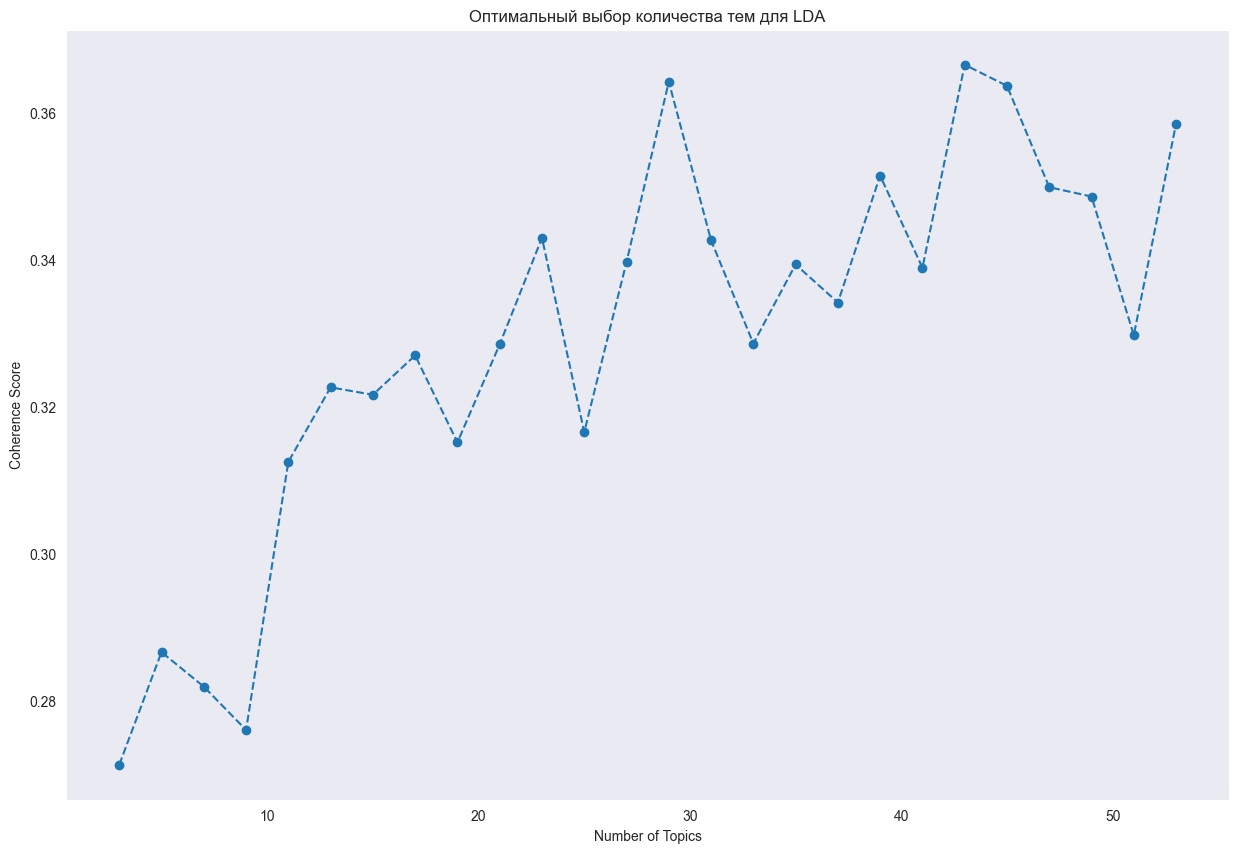

In [15]:
plt.figure(figsize=(15, 10))
plt.plot(topic_range, coherence_values, marker='o', linestyle='--')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Оптимальный выбор количества тем для LDA")
plt.grid()
plt.show()

оценим полученные результаты:

- при количестве топиков в 3-10 Coherence Score очень низкий

- лучший coherence score: 0.366 (43 темы)

- оптимальный баланс между количеством топиков и coherence score: 29 тем (0.364)


`разница в Coherence Score (0.002) минимальна, поэтому ключевой критерий – интерпретируемость`

проверим дополнительно эмперическим путем и сформируем окончательный вывод

#### доп проверка на оптимальный num_topics

- проверка меньшего количества тем (num_topics = 8)

In [62]:
lda_model_1_test, coherence_score_lda_1_test = train_evaluate_lda(
    tokens_=tokens,
    corpus_=corpus,
    dictionary_=dictionary,
    topics_=8
)

coherence_score_lda_1_test

0.29771753907656434

In [63]:
vis = pyLDAvis.gensim_models.prepare(lda_model_1_test, corpus, dictionary)
pyLDAvis.display(vis)

- как и ожидалось, с маленьким количеством тем, темы смешиваются и не достигают достаточной гранулярности 
- также темы сильно пересекаются, значит, модель плохо их разделяет
- ключевые слова в каждой из тем тоже +- принадлежат к одному множеству

также я заметил, что в большинстве тем преобладают термины, не совсем обладающие ценной информацией, поэтому добавим их в стоп-слова

In [14]:
custom_stopwords = ["model", "method", "using", "data", "task"]

In [15]:
set(tokens[0]) & set(custom_stopwords)

{'method', 'model', 'using'}

In [16]:
tokens = tokens.apply(lambda tokens: [word for word in tokens if word not in custom_stopwords])

tokens[0]

['video',
 'video',
 'generative',
 'adversarial',
 'network',
 'fewshot',
 'learning',
 'based',
 'policy',
 'gradient',
 'development',
 'sophisticated',
 'videotovideo',
 'synthesis',
 'facilitated',
 'recent',
 'advance',
 'deep',
 'reinforcement',
 'learning',
 'generative',
 'adversarial',
 'network',
 'gans',
 'paper',
 'propose',
 'new',
 'deep',
 'neural',
 'network',
 'approach',
 'based',
 'reinforcement',
 'learning',
 'unsupervised',
 'conditional',
 'videotovideo',
 'synthesis',
 'preserving',
 'unique',
 'style',
 'source',
 'video',
 'domain',
 'approach',
 'aim',
 'learn',
 'mapping',
 'source',
 'video',
 'domain',
 'target',
 'video',
 'domain',
 'train',
 'policy',
 'gradient',
 'employ',
 'convlstm',
 'layer',
 'capture',
 'spatial',
 'temporal',
 'information',
 'designing',
 'finegrained',
 'gan',
 'architecture',
 'incorporating',
 'spatiotemporal',
 'adversarial',
 'goal',
 'adversarial',
 'loss',
 'aid',
 'content',
 'translation',
 'preserving',
 'style',
 'u

In [17]:
assert set(custom_stopwords) not in set(tokens[0])

#### наблюдение №2

- оптимальный баланс между количеством топиков и coherence score: 29 тем (0.364)

In [18]:
dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]

In [19]:
lda_model_2_optim, coherence_score_lda_2_optim = train_evaluate_lda(
    tokens_=tokens,
    corpus_=corpus,
    dictionary_=dictionary,
    topics_=29
)

coherence_score_lda_2_optim

0.31881631742323246

интерактивная визуализация тем через PyLDAvis

In [18]:
vis = pyLDAvis.gensim_models.prepare(lda_model_2_optim, corpus, dictionary)
pyLDAvis.display(vis)

#### наблюдение №3

- лучший coherence score: 0.366 (43 темы)

In [19]:
lda_model_3_max, coherence_score_lda_3_max = train_evaluate_lda(
    tokens_=tokens,
    corpus_=corpus,
    dictionary_=dictionary,
    topics_=43
)

coherence_score_lda_3_max

0.3609886628366881

In [20]:
vis = pyLDAvis.gensim_models.prepare(lda_model_2_optim, corpus, dictionary)
pyLDAvis.display(vis)

#### анализ выбора количества тем (num_topics) в LDA

Интерпретируемость тем:

- При 8 темах:
    - темы достаточно плохо сформированы, очень размыто и нет четкой логической связки ключевых слов
    - также очень низкий coherence score
    - эмперически подтвердилось, что num_topics < 29 не оптимален

- При 43 темах:
    - тем значительно больше, потенциально более узкие и точные темы
    - Но! Возникает фрагментация, поскольку слишком много тем с небольшими отличиями
    - например: тема 5, тема 11, тема 28 – все про "action, recognition, evaluation"
    - тема 1 и тема 6 – обе содержат motion, frame, diffusion, temporal, вероятно, их можно объединить в одну группу тем


- При 29 темах:
    - тем меньше, темы более обобщенные
    - есть баланс между детализацией и читаемостью
    - например, video generation и video diffusion не раздроблены на несколько тем
    - также, некоторые темы могут быть несколько шире, например тема 6 охватывает и temporal, и spatial информацию
    - но не существенно, если сравнивать с избыточностью разделения тематик с num_topics=43, то размер в 29 тем существенно лучше интрепретировать


**Вывод:**

`num_topics=29 – оптимальный вариант`

- чуть ниже Coherence Score, но лучше интерпретируемость

- темы не раздроблены на мелкие аспекты

- не теряется бизнес-смысл, можно выделить ключевые тренды, а не просто набор разрозненных понятий




Ниже представлен скриншот визуализации работы LDA алгоритма, который не отобразился в Jupyter Notebook

`num_topics = 29`


![](../../assets/lda.png)

#### Анализ трендов с LDA (num_topics=29)

- Проанализируем подробнее полученные темы с ключевыми словами и сформируем тренды

In [20]:
from colorama import Fore, Style

In [21]:
print("=" * 50)
print("Темы, выделенные LDA-моделью (num_topics=29):")
print("=" * 50)

for idx, topic in lda_model_2_optim.print_topics(-1):
    keywords = ", ".join([word.split("*")[1].replace('"', '').strip() for word in topic.split(" + ")])
    print(f"\nТема {idx + 1}:")
    print(f"Ключевые слова: {Fore.BLUE}{keywords}{Style.RESET_ALL}")
print("=" * 50)

Темы, выделенные LDA-моделью (num_topics=29):

Тема 1:
Ключевые слова: video, motion, human, pose, generation, novel, image, framework, propose, diffusion

Тема 2:
Ключевые слова: caption, speech, longcontext, video, biasing, captioning, language, audiovisual, recognition, asr

Тема 3:
Ключевые слова: video, game, learning, map, approach, image, play, representation, historical, entity

Тема 4:
Ключевые слова: image, diffusion, medical, depth, based, segmentation, ct, tumor, compared, pet

Тема 5:
Ключевые слова: video, generation, quality, editing, dataset, image, modality, foundation, framework, content

Тема 6:
Ключевые слова: video, generation, temporal, information, frame, propose, spatial, attention, module, multimodal

Тема 7:
Ключевые слова: analysis, slide, audio, hallucination, generation, note, paper, accuracy, methodology, advanced

Тема 8:
Ключевые слова: video, hdr, range, image, dynamic, communication, estimation, generative, network, existing

Тема 9:
Ключевые слова: di

обучив LDA мы получили 29 тем с ключевыми словами, теперь интерпретируем полученную информацию в некий топ трендов по тематике `видео генерация`

### `№1` в качестве первого способа и получения первого представления, проанализируем ключевые слова самостоятельно и сформируем группы трендов на основе них

-----

результат моего анализа (ручной анализ):

#### основные тренды в видео генерации в 2024 (`LDA` num_topics=29)

Тренды:

1. диффузионные модели для видео генерации 

- (темы: 1, 5, 6, 12, 21, 26, 29)
- ключевые слова: video, diffusion, generation, image, frame, network, multimodal
- суть: использование diffusion Models для генерации видео, улучшения качества, текстур-фреймов, мультимодальных приложений


2. улучшение качества + редактирование видео

- (темы: 5, 8, 25, 27)
- ключевые слова: motion, action, pose, temporal, spatial, detection, recognition
- суть: генерация видео с высоким разрешением, обработка динамического диапазона HDR


3. распознавание + генерация движений в видео

- (темы: 1, 6, 11, 16, 19)
- ключевые слова: motion, action, pose, temporal, spatial, detection, recognition
- суть: генерация анимации статических поз человекоподобных персонажей


4. видео-аннотации, мультимодальный анализ

- (темы: 2, 19, 28)
- ключевые слова: caption, speech, annotation, benchmark, multimodal, segmentation
- суть: автоматическое добавление текстовых описаний к видео, генерация видео на основе LLM


5. рендеринг-методы NeRF и Light Field

- (темы: 17, 18)
- ключевые слова: nerf, radiance, rendering, lightfield, highquality
- суть: использование NeRF и Light Field для генерации реалистичных видеоизображений


6. робототехника и навигация

- (темы: 10, 22, 24)
- ключевые слова: robot, policy, navigation, obstacle, zeroshot, planning
- суть: применение видеогенерации в задачах робототехники, симуляции и в RL


7. medtech

- (темы: 4, 9, 26)
- ключевые слова: medical, segmentation, ct, mri, ultrasound
- суть: видеогенерация и обработка изображений в медицинской сфере, анализ КТ/МРТ и улучшение качества изображений

### `№2` в качестве второго способа, попробуем автоматизировать выделение ключевых трендов 

#### основные тренды в видео генерации в 2024 (`LDA` num_topics=29)

-----

по следующему принципу:

- берем темы из LDA со списком ключевых слов по каждой теме
- делаем кластеризацию по смыслу (BERT + UMAP + HDBSCAN)
- формируем названия глобальных трендов
- интерпретируем c KeyBERT + LLM
- визуализируем с WordCloud, UMAP

In [22]:
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

In [23]:
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import numpy as np
from wordcloud import WordCloud
from keybert import KeyBERT

In [24]:
topics = lda_model_2_optim.show_topics(
    num_topics=-1,
    formatted=False
)

topics_dict = {i: [word for word, _ in words] for i, words in topics}

for i, words in list(topics_dict.items())[:3]:
    print(f"Тема {i}: {', '.join(words)}\n")

Тема 0: video, motion, human, pose, generation, novel, image, framework, propose, diffusion

Тема 1: caption, speech, longcontext, video, biasing, captioning, language, audiovisual, recognition, asr

Тема 2: video, game, learning, map, approach, image, play, representation, historical, entity


In [25]:
model = SentenceTransformer('all-MiniLM-L6-v2')

topic_embeddings = np.array(
    [model.encode(' '.join(words)) for words in topics_dict.values()]
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

D:\PycharmProjects\video_gen_trends_analysis\.venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\nikdf\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [26]:
topic_embeddings

array([[-3.2368011e-03, -7.7753611e-02, -8.9229911e-04, ...,
        -1.8003415e-02,  1.3777495e-02, -3.5613533e-03],
       [-3.7472334e-02, -9.8756604e-02, -1.8959070e-02, ...,
         2.4373829e-03, -5.9081330e-03, -2.7211625e-02],
       [ 6.9619082e-02, -7.9782344e-03, -1.6941622e-02, ...,
        -3.1085901e-02, -3.3091851e-02,  5.4286491e-02],
       ...,
       [ 1.1112291e-01,  2.4837684e-02, -2.8345864e-02, ...,
         4.9268242e-02, -9.2328053e-05, -6.2529176e-02],
       [-1.3067466e-02, -6.3748144e-02, -3.3610035e-02, ...,
         6.7869283e-02,  2.3336796e-02, -4.8246123e-02],
       [ 3.4702443e-02, -7.4989721e-02,  7.2079793e-02, ...,
         2.2159928e-02, -4.9044606e-03, -1.0134600e-02]], dtype=float32)

In [27]:
topic_embeddings.shape

(29, 384)

In [28]:
reducer = umap.UMAP(
    n_components=5,
    random_state=42
)

umap_embeddings = reducer.fit_transform(
    topic_embeddings)

umap_embeddings.shape

D:\PycharmProjects\video_gen_trends_analysis\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(29, 5)

In [29]:
umap_embeddings

array([[ 5.3588748e+00,  9.1207733e+00, -5.3158860e+00, -3.6772245e-01,
         2.3331697e+00],
       [ 5.5912952e+00,  9.0314236e+00, -5.1628046e+00, -2.7776009e-01,
         1.3680688e+00],
       [ 5.6418157e+00,  8.1382504e+00, -5.4421954e+00, -7.6809329e-01,
         1.8866441e+00],
       [ 6.1290736e+00,  9.5763359e+00, -5.1191025e+00, -1.1045526e+00,
         3.2162135e+00],
       [ 5.5312490e+00,  9.3829937e+00, -5.0732198e+00, -9.0311754e-01,
         2.0504911e+00],
       [ 5.4029665e+00,  8.8063011e+00, -4.5678468e+00, -3.9755750e-01,
         1.8485304e+00],
       [ 6.1321707e+00,  9.8119240e+00, -5.1303544e+00, -7.7606755e-01,
         2.4793282e+00],
       [ 5.9075861e+00,  8.9916725e+00, -4.5762892e+00, -1.4001967e+00,
         2.2421470e+00],
       [ 6.4885221e+00,  9.1760578e+00, -4.3762946e+00, -1.1411228e+00,
         3.2944493e+00],
       [ 5.3204889e+00,  8.1609774e+00, -4.3926048e+00, -3.0018413e-01,
         2.3873131e+00],
       [ 5.5175948e+00,  8.491

In [30]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2, 
    gen_min_span_tree=True
)

labels = clusterer.fit_predict(umap_embeddings)

df_topics = pd.DataFrame(
    {
        "topic_id": list(topics_dict.keys()), 
        "keywords": list(topics_dict.values()), 
        "cluster": labels
    }
)

df_topics["cluster"].value_counts()

cluster
 0    11
-1     6
 3     6
 2     4
 1     2
Name: count, dtype: int64

In [52]:
print(df_topics["cluster"].value_counts())

cluster
 0    11
-1     6
 3     6
 2     4
 1     2
Name: count, dtype: int64


In [31]:
kw_model = KeyBERT()

cluster_keywords = {
    label: sum([topics_dict[i] for i in df_topics[df_topics["cluster"] == label]["topic_id"]], []) for label in set(labels)
}

In [48]:
def generate_trend_name(words):
    keywords = kw_model.extract_keywords(" ".join(words), keyphrase_ngram_range=(1, 3), top_n=5)
    return " / ".join([kw[0] for kw in keywords])

In [49]:
trend_names = {cluster: generate_trend_name(words) for cluster, words in cluster_keywords.items()}

for cluster, name in trend_names.items():
    print(f"-----> Тренд {cluster}:\n{Fore.GREEN}{name}{Style.RESET_ALL} ({', '.join(cluster_keywords[cluster][:5])})\n")

-----> Тренд 0:
trained image diffusion / datasets diffusion image / approach video diffusion / diffusion segmentation datasets / video diffusion description (video, motion, human, pose, generation)

-----> Тренд 1:
video hdr range / scene dynamic hdr / hdr range image / optical map network / image dynamic communication (video, hdr, range, image, dynamic)

-----> Тренд 2:
video game learning / challenge analysis video / game learning map / image play representation / video annotation dataset (video, game, learning, map, approach)

-----> Тренд 3:
spatial event camera / egocentric wifi robot / object egocentric wifi / object egocentric / visual safe obstacle (object, egocentric, wifi, robot, long)

-----> Тренд -1:
speech longcontext video / caption speech / caption speech longcontext / captioning language audiovisual / video biasing captioning (caption, speech, longcontext, video, biasing)


Cluster 0:

video motion human pose generation novel image framework propose diffusion image diffusion medical depth based segmentation ct tumor compared pet video generation quality editing dataset image modality foundation framework content analysis slide audio hallucination generation note paper accuracy methodology advanced disparity image proposed field ultrasound based scheme imaging result datasets diffusion image approach video process output frame training however across nerf proposed neural pipeline radiance gb study network field image neural view face multiview representation lightfield highquality rendering pipeline approach video diffusion description network user audio representation music generation trained image diffusion segmentation datasets training generative network generation mri mask image diffusion highfrequency sr network latent dose generative neural inr


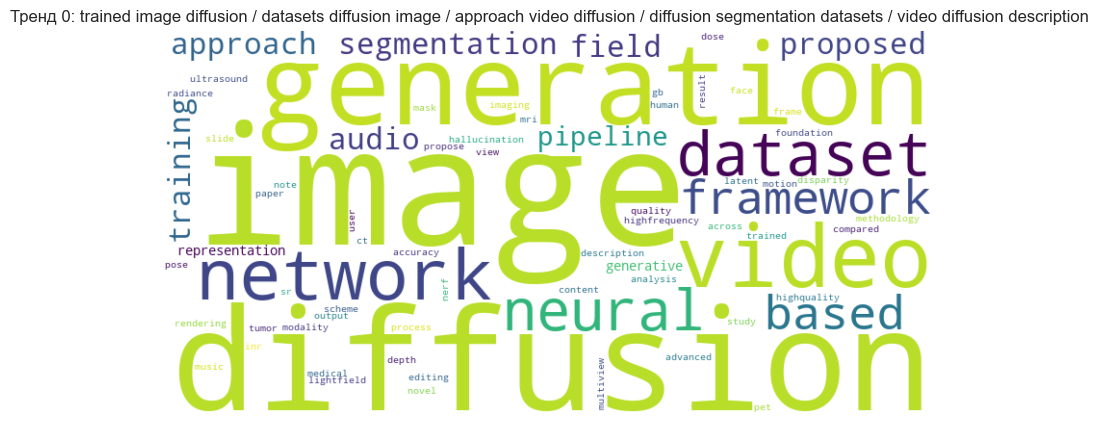

Cluster 1:

video hdr range image dynamic communication estimation generative network existing scene dynamic hdr graph flow range object optical map network


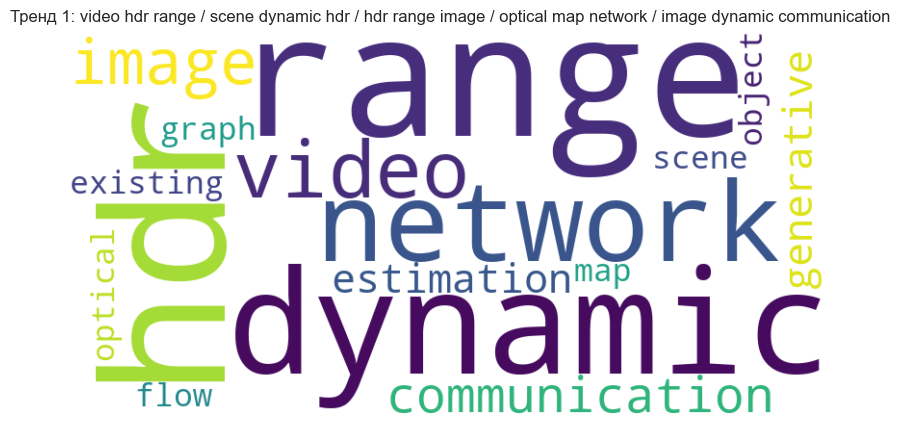

Cluster 2:

video game learning map approach image play representation historical entity action video detection instance recognition learning framework anomaly temporal paper video content streaming frame sport hierarchical approach user challenge analysis video annotation dataset human benchmark approach facial expression frame preference


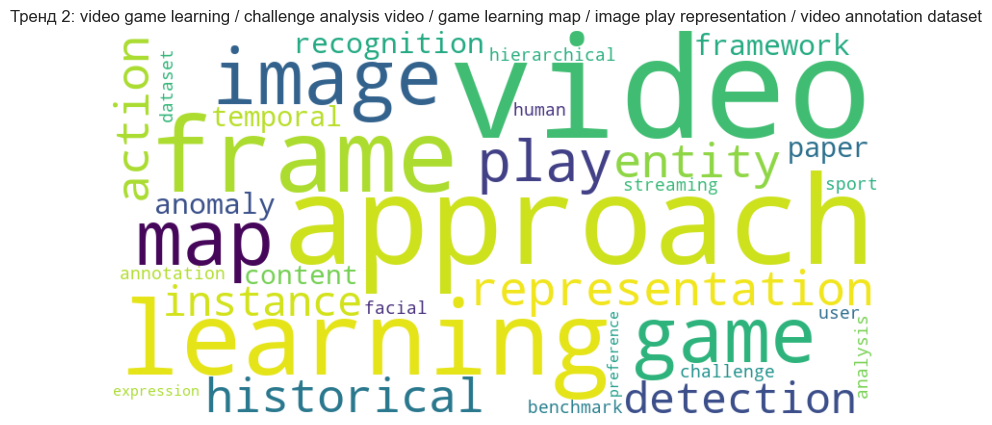

Cluster 3:

object egocentric wifi robot long frame observation time even spatial event camera inpainting video spatial clue map temporal optimization eventbased video understanding object multimodal benchmark surgical segmentation question language reasoning driver knowledge behavior globaltolocal pose road safety accuracy create camera policy manipulation robot planning object transfer simulation scene local zeroshot navigation visual safe obstacle llm realtime accessibility scene potential transition


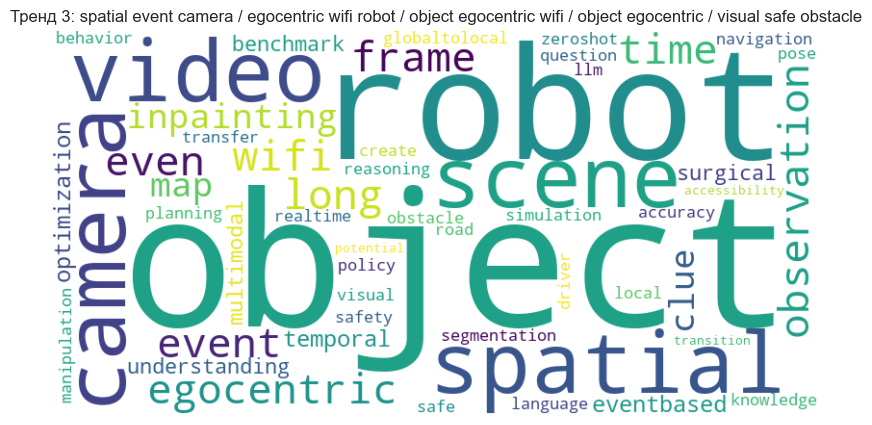

Cluster -1:

caption speech longcontext video biasing captioning language audiovisual recognition asr video generation temporal information frame propose spatial attention module multimodal affordance multicast axis dt campus roboabc keypoint articulated videgothink twin image ad imaging ai military mechanism illumination public system light point cloud sequence processing learning representation dynamic temporal compression efficient video evaluation performance frame visual efficient prompt network image information


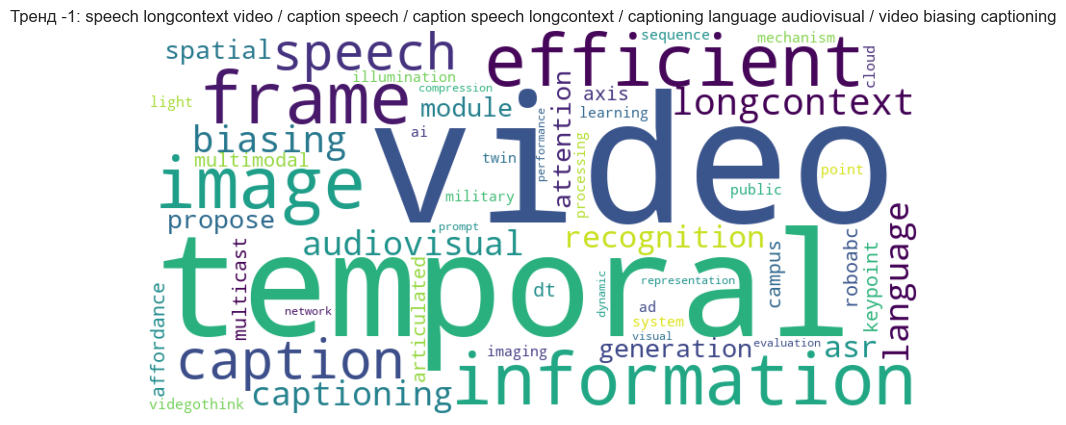

In [50]:
for cluster, words in cluster_keywords.items():
    print(f"Cluster {cluster}:\n\n{" ".join(words)}")
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Тренд {cluster}: {trend_names[cluster]}")
    plt.show()


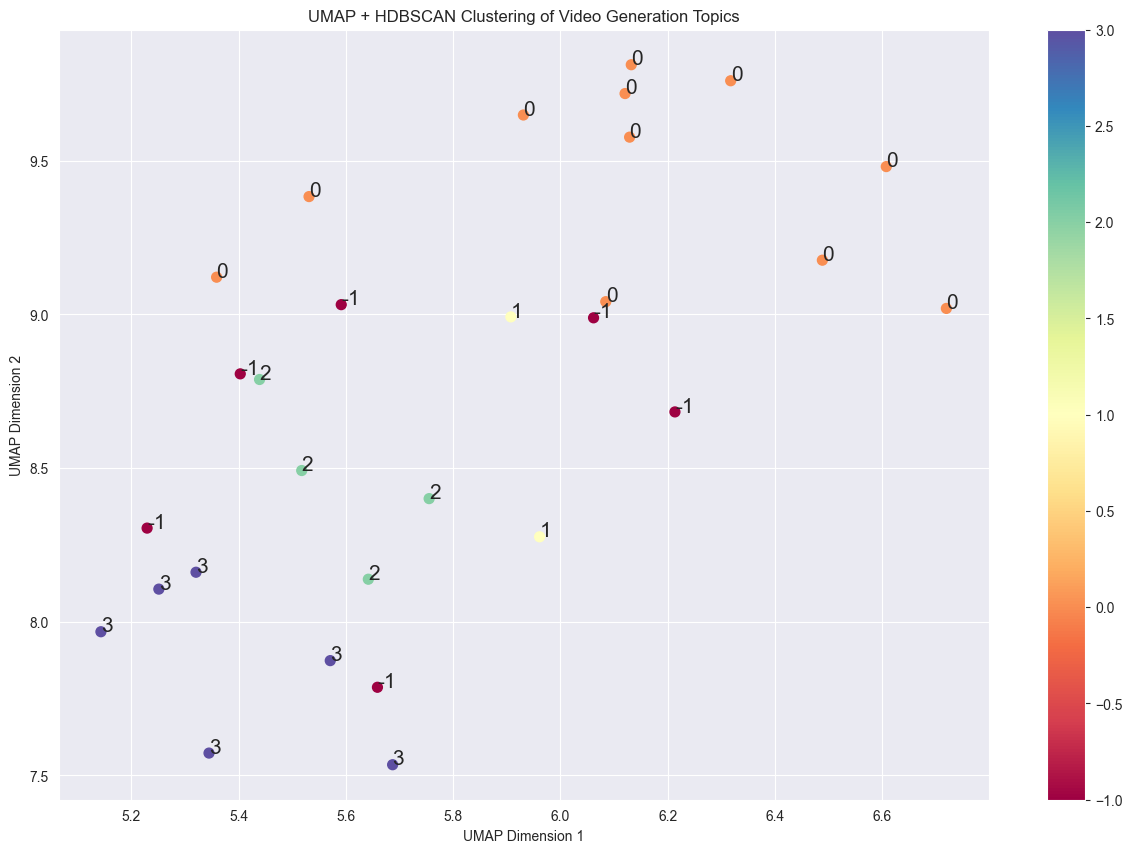

In [51]:
plt.figure(figsize=(15, 10))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap="Spectral", s=50)

plt.colorbar(scatter)
plt.title("UMAP + HDBSCAN Clustering of Video Generation Topics")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")


for i, txt in enumerate(df_topics["cluster"]):
    plt.annotate(txt, (umap_embeddings[i, 0], umap_embeddings[i, 1]), fontsize=15)

plt.show()

### Оценка выделенных трендов

1. Тренд: Diffusion-модели для генерации и обработки видео и изображений

ключевые темы:

- Генерация видео (human pose, motion, novel image)
    
- Diffusion-модели (image/video diffusion, medical imaging, segmentation)
    
- Нейросетевые подходы (NeRF, radiance fields, multiview rendering)
    
- Обработка медицинских данных (MRI, CT, ultrasound)

суть: `применение diffusion-моделей для реалистичной генерации и редактирования видео, включая медицинские задачи`

-----

2. Тренд: Dynamic HDR & Image Processing


ключевые темы:

- Основной фокус на HDR, динамический диапазон, оптические карты, видеообработку

- Оптимизация цветопередачи, оценку диапазона

суть: `тренд связан с улучшением качества видео, HDR-контентом, генеративными моделями для улучшения качества`

`растёт спрос на технологии улучшения динамического диапазона и реалистичности видео (например, для кино, игр, AR/VR)`

-----

3. Тренд: AI in Gaming & Video Learning

ключевые темы:

- Включает анализ видео, игровые обучающие системы, анимацию
- По сути тренд на геймификацию обучения, генерации релевантных уникальных видео и тд
- Акцент на детекции объектов, распознавании эмоций, стриминге, анализе игроков

-----

4. Тренд: Egocentric Vision & Robotics

ключевые темы:

- Egocentric-видео

- Навигация роботов (wifi-based localization, obstacle avoidance)

- Event cameras (обработка событийных данных в реальном времени)

суть: `Большой спрос на видео генерацию для обучения робототехнических систем, для автономных роботов, особенно в комбинации с камерами событийного типа`

 -----
 
* Тренд на основе минорного кластера (-1)

- Мультимодальные модели для обработки видео и аудио


ключевые темы:

- speech captioning, long-context video
- мультимодальное обучение (audiovisual recognition, ASR)
- сжатие и обработка видео

суть: `можно сделать вывод, что растет интерес к моделям, объединяющим анализ видео, аудио и текста`

# Вывод по тематическому моделированию LDA для анализа трендов видео генерации

1. Сравнение двух подходов (LDA и кластеризация BERT+UMAP+HDBSCAN)

**Классическое тематическое моделирование (LDA)**

- Позволило выделить 29 тематик
- Основные темы были сгруппированы вручную в 7 глобальных трендов
- Дает хорошее представление о распределении ключевых тем, но требует экспертного анализа для объединения схожих тем


**LDA + кластеризация с SBERT + UMAP + HDBSCAN**

- для каждой темы на основе полученных LDA ключевых слов получили эмбеддинги с помощью упрощенной модели SBERT (на основе архитектуры MiniLM)
- было выполнено снижение размерности полученных векторов с помощью UMAP для визуализации и кластеризации
- выполнена кластеризация с помощью алгоритма HDBSCAN (так он устойчив к шуму и динамически определяет число кластеров) 
- кластеры формировались на основе семантической близости

- Удалось выявить 5 ключевых трендов
- Выявлен минорный тренд, связанный с мультимодальными моделями для обработки видео и аудио

-----

Оба подхода дали согласованные результаты, что подтверждает надежность выявленных закономерностей

2. Выводы о ключевых трендах

тренды видео генерации в 2024 сформированные на основе LDA + ручного анализа и (LDA + SBERT + UMAP + HDBSCAN) почти полностью совпадают

Основные пересекающиеся тренды


#### Тренд №1: `Генерация видео на основе diffusion-моделей`

Суть: 

- Diffusion-модели стали стандартом для создания реалистичного видео, в особенности:

- Генерацию кадров из текста/позы (human pose, motion)

- Медицинские потребности (сегментация МРТ, улучшение КТ)

- Мультимодальные сценарии (видео + текст + аудио)


#### Тренд №2: `Повышение качества видео: HDR и динамические сцены`

Суть: 

- Акцент на технологиях, которые делают видео более детализированным и реалистичным
- HDR (расширенный динамический диапазон)
- Оптический поток (optical flow) для плавности движений
- Генеративные модели для ретуши и апскейлинга


#### Тренд №3: `Распознавание + генерация движений`

Суть: 

- Анимация персонажей (pose, action)
- Распознавание действий и их дорисовка
- Применение в играх


#### Тренд №4: `Мультимодальность: видео + текст + аудио`

Суть: 

Растёт спрос на системы, которые объединяют разные типы данных

- Автоматические субтитры (speech captioning)
- Генерация видео из текста (LLM + video)
- Обработка длинных видео (long-context)


#### Тренд №5: `Применение видеогенерации в робототехнике и медицине`

Суть:

Видеогенерация и анализ критичны для:

- Навигации роботов (obstacle avoidance, event cameras)
- Медицинской визуализации (MRI, CT, ultrasound)

### 3.1.2 Тематическое моделирование с NMF

также добавим больше итераций, поскольку по умолчанию за 200 итераций он не достигает полной сходимости

In [54]:
from sklearn.decomposition import NMF

nmf_model = NMF(
    n_components=10,
    random_state=42,
    max_iter=500
)

nmf_topics = nmf_model.fit_transform(df_lemm_tfidf)

In [55]:
feature_names = tfidf_vectorizer.get_feature_names_out()
num_words = 10

In [59]:
def get_top_words(model, feature_names, num_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        topics.append(top_features)
        print(f"Тема {topic_idx+1}:\n{', '.join(top_features)}\n\n")
    return topics

In [60]:
topics = get_top_words(nmf_model, feature_names, num_words)

Тема 1:
diffusion, diffusion model, model, generation, video diffusion, video, video diffusion model, latent, image, video generation


Тема 2:
language, understanding, language model, llm, large, large language, large language model, video, multimodal, video understanding


Тема 3:
image, adversarial, network, adversarial network, generative adversarial, generative adversarial network, generative, gans, gan, medical


Тема 4:
video, segmentation, object, action, learning, task, detection, method, data, feature


Тема 5:
talking, facial, head, talking head, face, audio, portrait, lip, audiodriven, expression


Тема 6:
audio, generation, video, evaluation, video generation, model, metric, content, texttovideo, dataset


Тема 7:
quality assessment, assessment, video quality, quality, video quality assessment, vqa, compression, ugc, database, content


Тема 8:
scene, view, novel view, gaussian, view synthesis, reconstruction, dynamic, multiview, novel view synthesis, rendering


Тема 9:
d

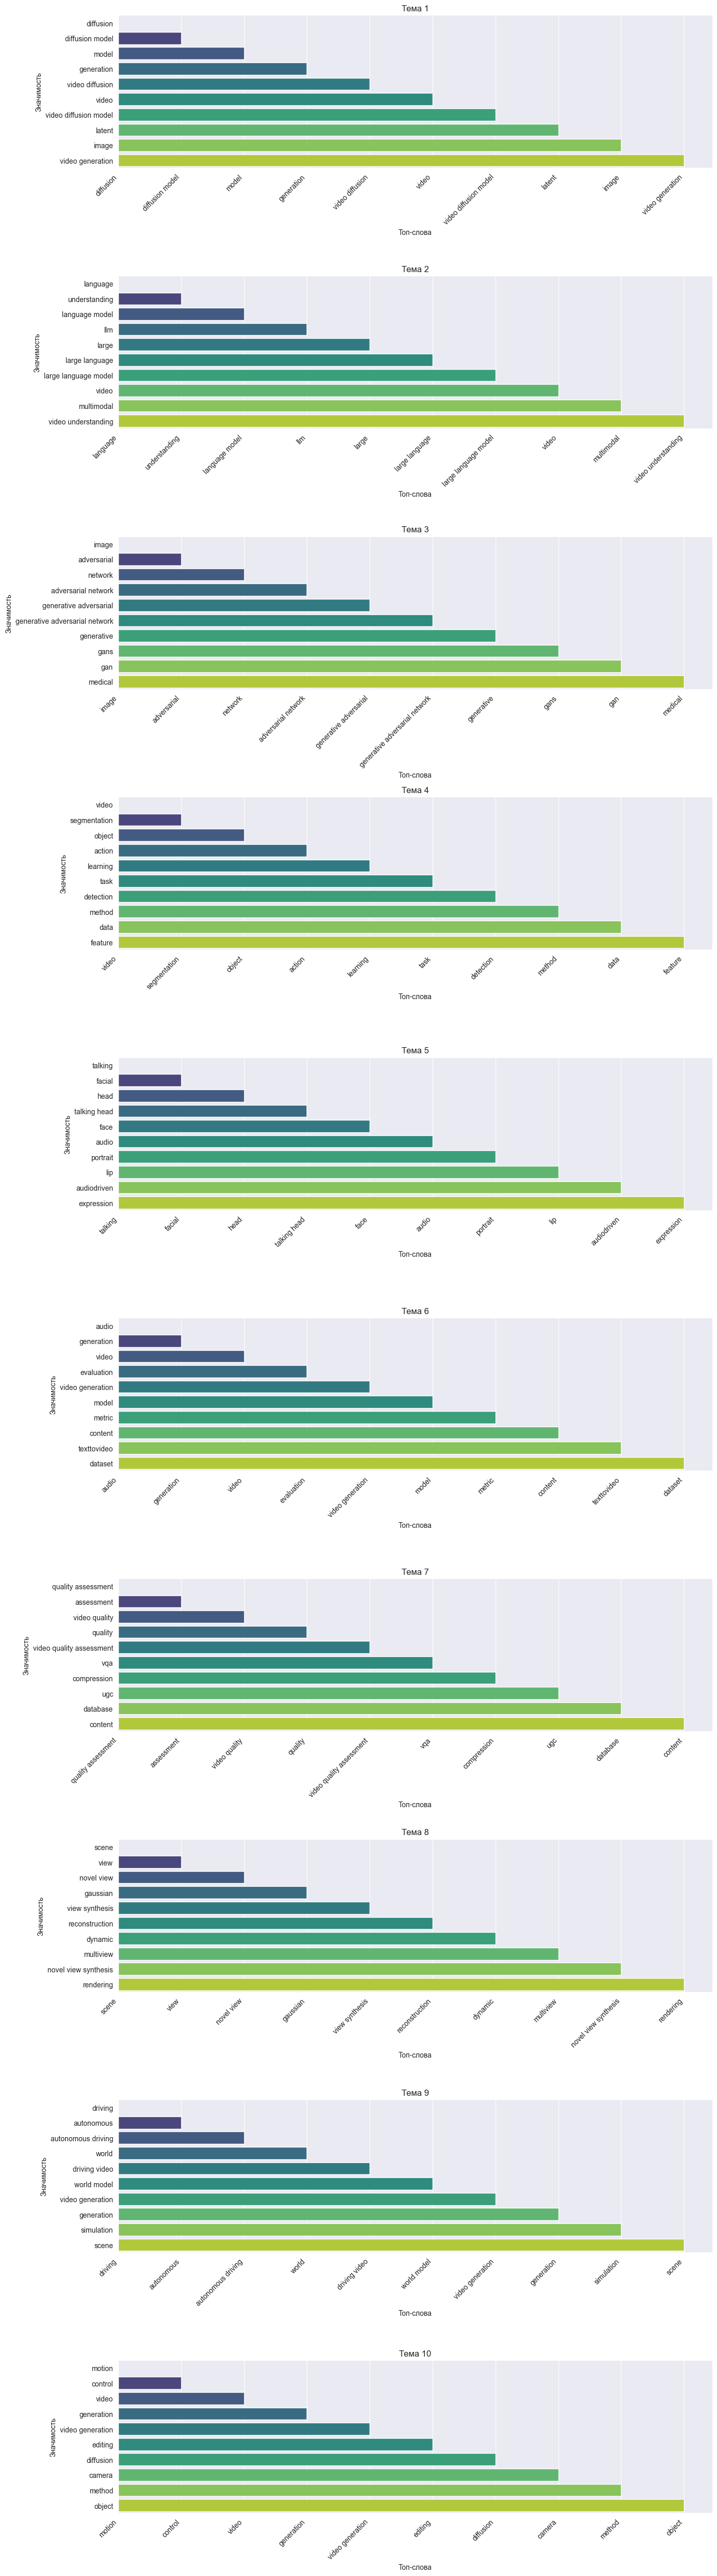

In [64]:
def plot_nmf_topics(topics, num_words=10):
    plt.figure(figsize=(14, len(topics) * 5))
    
    for i, topic in enumerate(topics):
        plt.subplot(len(topics), 1, i + 1)  # Размещаем графики вертикально
        sns.barplot(x=list(range(num_words)), y=topic, palette="viridis")
        plt.xticks(range(num_words), topic, rotation=45, ha="right")
        plt.xlabel("Топ-слова")
        plt.ylabel("Значимость")
        plt.title(f"Тема {i+1}")
    
    plt.tight_layout()
    plt.show()

plot_nmf_topics(topics)

- подберем оптимальный n_components по coherence score